In [1]:

import numpy as np
import emcee 
import itcfunctions as itc
from multiprocessing import Pool

##some params that cannot easily be read
Kb = 0.001987
T = 273.15+25
V0 = 1.42e-3




def get_data(file_name):
    inj_list = np.empty(shape=(0))
    dq_list = np.empty(shape=(0))
    with open(file_name+'.dat') as F:
        for line in F:
            values = line.strip('\n').split()
            if values[0] != 'DH' and values[0] != '-':
                inj_list = np.append(inj_list,float(values[1])*1e-6)
                dq_list = np.append(dq_list,float(values[0]))
    return [inj_list],dq_list
            


In [2]:

### 7 parameter itc model sampling

def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    curr_sigma = theta[-1]
    y_pred = itc.get_dq_list(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],extra_parameters[0])
    
    
    #only necessary when working with real data (synth data only has 1st pt removed)
    #y_pred[1] = 0

    # calculate normal log likelihood
    logl = -len(y_obs) * np.log(np.sqrt(2.0 * np.pi) * curr_sigma)
    logl += -np.sum((y_obs - y_pred) ** 2.0) / (2.0 * curr_sigma ** 2.0) 
    return logl


def log_prior(theta):
    '''log of uniform prior distribution'''
    pt_true = theta_true[4]
    lt_true = theta_true[5]

    dg = theta[0]
    ddg = theta[1]
    dh = theta[2]
    ddh = theta[3]
    pt = theta[4]
    lt = theta[5]
    dh_0 = theta[6]
    sigma = theta[-1]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if 0.001<sigma<1 and -10<dg<-5 and -4.1<ddg<4.1 and -20<dh<0 and -10<ddh<10 \
        and (pt_true-pt_true*concprior_range)<pt<(pt_true+pt_true*concprior_range) and (lt_true-lt_true*concprior_range)<lt<(lt_true+lt_true*concprior_range) and -10<dh_0<10:
        return 0  
    else:
        return -np.inf


def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, extra_parameters)  # log posterior ~ log likelihood + log prior

# initialization

conc_priors = True


#filename for save and for plots
filename = 'stretch_snooker_05_run1'


#hijacking old architecure for now. will need to rewrite it in the future
#extra_parameters,y_obs = get_data('bsn_seq_3')
#print(extra_parameters,y_obs)
#designating concs in-script is easiest for now
seed = 404
true_y, y_obs,theta_true,extra_parameters = itc.get_synthetic_itc(seed,conc_priors)

#reseed for random starts if needed
seed = 456
np.random.seed(seed)

pt_ref = theta_true[4]
lt_ref = theta_true[5]
n_dim = 8


# sampler settings
n_walkers = 50  # at least 3x the number of parameters
n_steps = int(1e2)  # at least 50x the autocorrelation time

concprior_range = 0.05



# Set up the backend -- emcee's built in stuff seems fairly legit
# Don't forget to clear it in case the file already exists
backend = emcee.backends.HDFBackend(f'save_{filename}.dat')
backend.reset(n_walkers, n_dim)



# random starts from uniform priors
pos_list = []
for i in range(n_walkers):
    sigma_i = np.random.uniform(0.001,1)
    dg_i = np.random.uniform(-10,-5)
    ddg_i = np.random.uniform(-4,4)
    dh_i = np.random.uniform(-20,0)
    ddh_i = np.random.uniform(-10,10)
    pt_i = np.random.uniform(pt_ref-pt_ref*concprior_range, pt_ref+pt_ref*concprior_range)
    lt_i = np.random.uniform(lt_ref-lt_ref*concprior_range, lt_ref+lt_ref*concprior_range)
    dh_0_i = np.random.uniform(-10,10)
    pos_list.append([dg_i,ddg_i,dh_i,ddh_i,pt_i,lt_i,dh_0_i,sigma_i])
start_pos = np.asarray(pos_list)

# run emcee ensemble sampler
with Pool(processes=4) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability,  args=(y_obs,extra_parameters),
                                    backend=backend, pool=pool, 
                                    moves=[(emcee.moves.DEMove(),0),(emcee.moves.DESnookerMove(),0.20),
                                          (emcee.moves.StretchMove(),0.8)])
    sampler.run_mcmc(start_pos, n_steps, progress=True)





true_dq: [  0.         -30.31450082 -30.64420777 -30.82759079 -30.93068147
 -30.97607951 -30.96953361 -30.90634046 -30.77129433 -30.53415778
 -30.13875869 -29.47993448 -28.35707981 -26.39631073 -23.02245988
 -17.91091022 -12.10157968  -7.47083118  -4.59473658  -2.95528462
  -2.0073958   -1.43223993  -1.06443029  -0.81778433  -0.64552974
  -0.52103343  -0.42841313  -0.35779455  -0.30280859  -0.25921225
  -0.22409778  -0.19542217  -0.17171799  -0.15191044  -0.13519838
  -0.12097522]


Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/BayesGrid/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/miniconda3/envs/BayesGrid/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/miniconda3/envs/BayesGrid/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/miniconda3/envs/BayesGrid/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
  File "/opt/miniconda3/envs/BayesGrid/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
AttributeError: Can't get attribute 'log_probability' on <module '__main__' (built-in)>
  File "/opt/miniconda3/envs/BayesGrid/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self.

KeyboardInterrupt: 

[141.06998014 139.60785589 139.34893849 128.8645653  149.78235416
 146.8483136   47.1511454  162.21949096]


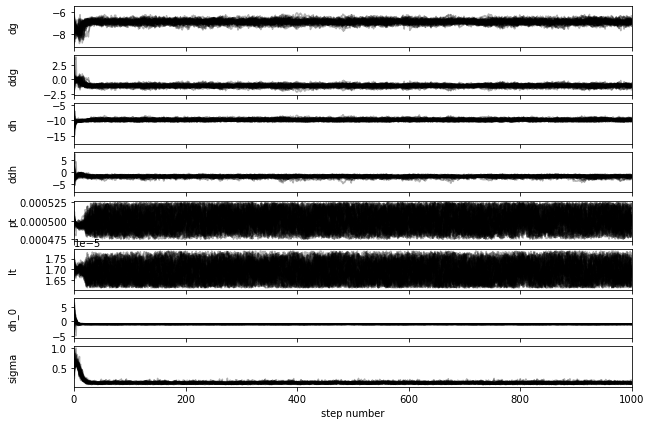

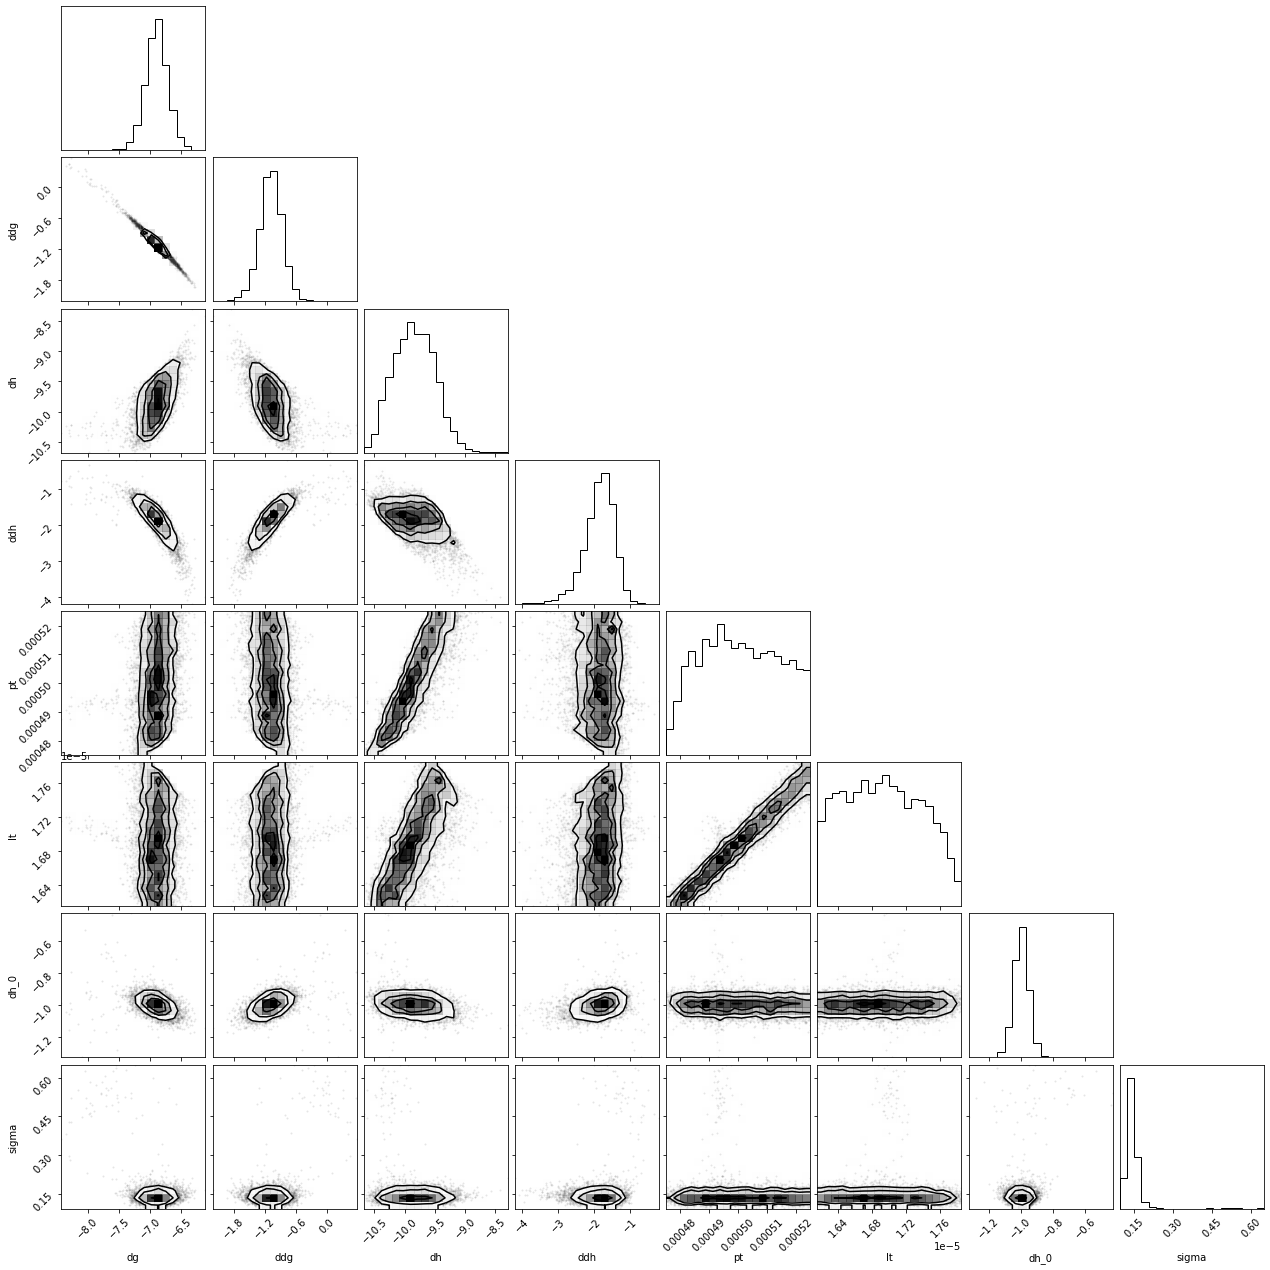

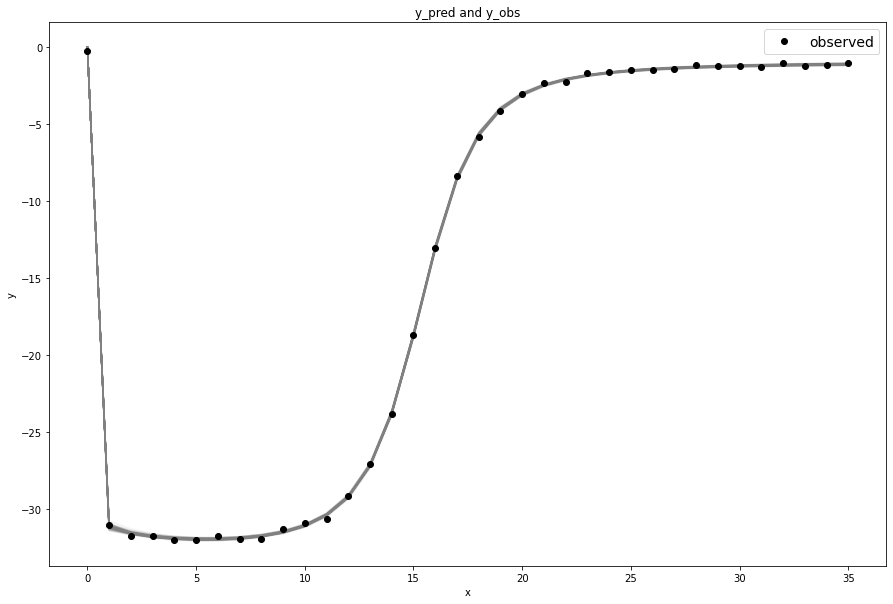

In [19]:
### 7 parameter itc model analysis
import matplotlib.pyplot as plt
import corner 

#retrieve saved data (not always needed, comment out when unused)
import emcee
import numpy as np
import itcfunctions as itc
#filename = 'default_05_run1'
sampler = emcee.backends.HDFBackend(f'save_{filename}.dat')
print(sampler)

samples = sampler.get_chain(thin=10)
n_dim = len(samples[0][1])


burn_in = 0

# mcmc trajectory (before burn in)
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
labels = ["dg", "ddg", "dh", "ddh", "pt", "lt", "dh_0", "sigma"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0,1000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f'{filename}_traces.png')
# autocorrelation time (for measuring sampling performance)
# note: this can give an error if the run length isn't 50x the autocorrelation
tau = sampler.get_autocorr_time()
print(tau)


# corner plot (1d and 2d histograms)

flat_samples = sampler.get_chain(discard=burn_in, thin=100, flat=True)
n_v_list = [122,122,122,122,122,122,122]
theta_true = [-7,-1,-10,-1.5, 0.0005, 1.7e-05, 0.2]
bounds = [(-9,-5),(-4,4),(-20,0),(-10,10),(0.0005-0.0005*0.05,0.0005+0.0005*0.05), ((1.7e-05)-(1.7e-05)*0.05, (1.7e-05)+(1.7e-05)*0.05), (0.001,0.5)]
auto = True

if not auto:
    fig = corner.corner(
        flat_samples, labels=labels, truths=theta_true,
        bins=n_v_list, range = bounds, plot_contours=True,
        plot_density=True,
    )
else:
    fig = corner.corner(
        flat_samples, labels=labels,
    )
plt.savefig(f'{filename}_2dcorr.png')


# plot y_predicted and y_observed
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize = (15, 10))
for ind in inds:
    sample = flat_samples[ind]
    y_pred_i = itc.get_dq_list(sample[0],sample[1],sample[2],sample[3],
                                sample[4], sample[5], sample[6],extra_parameters[0])
    #y_pred_i[1]=0
    plt.plot(y_pred_i, alpha=0.1, color='grey')
plt.title('y_pred and y_obs')
plt.ylabel('y')
plt.xlabel('x')

plt.plot(y_obs, ls='None', color='black', marker='o',label="observed")
plt.legend(fontsize=14)

plt.savefig(f'{filename}_example_plots.png')

In [10]:
plt.savefig('example_poor_output_traces.png')

<Figure size 432x288 with 0 Axes>